In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [11]:
# Load and prepare data
data = pd.read_csv('mongodb_data_export.csv')
data = data.dropna(subset=['timestamp'])
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')
data.dropna(subset=['timestamp'], inplace=True)
data.set_index('timestamp', inplace=True)
data.dropna(inplace=True)

In [12]:
# Get list of unique directories
directories = data['directory'].unique()

In [13]:
# Forecast shifts
shifts = {
    'storage_1day': 96,
    'storage_1week': 96 * 7,
    'storage_1month': 96 * 30,
    'storage_3month': 96 * 90
}


In [14]:
# Dictionary to store results for each directory
all_results = {}



Processing directory: /scratch


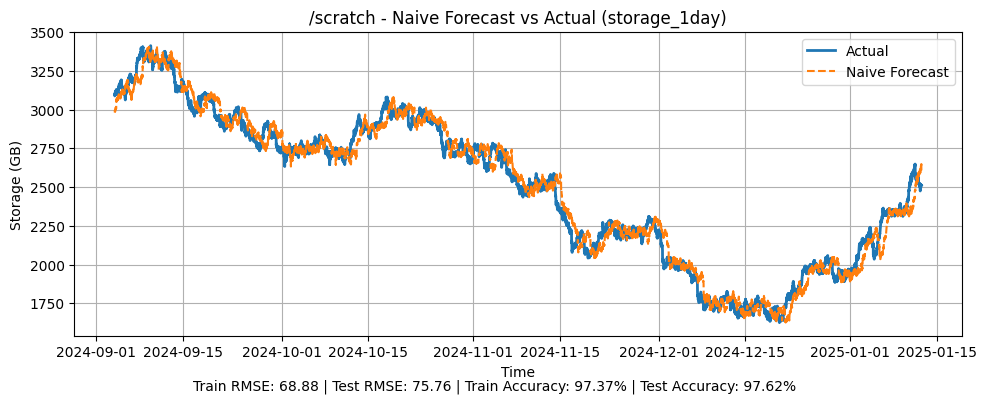

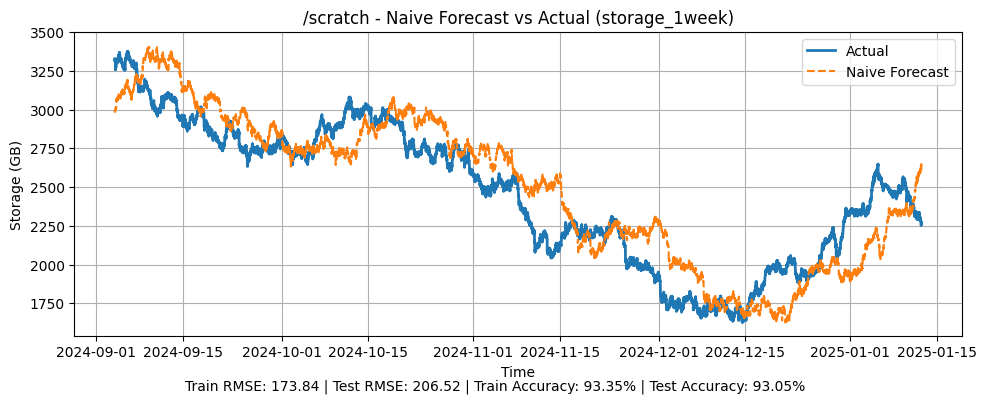

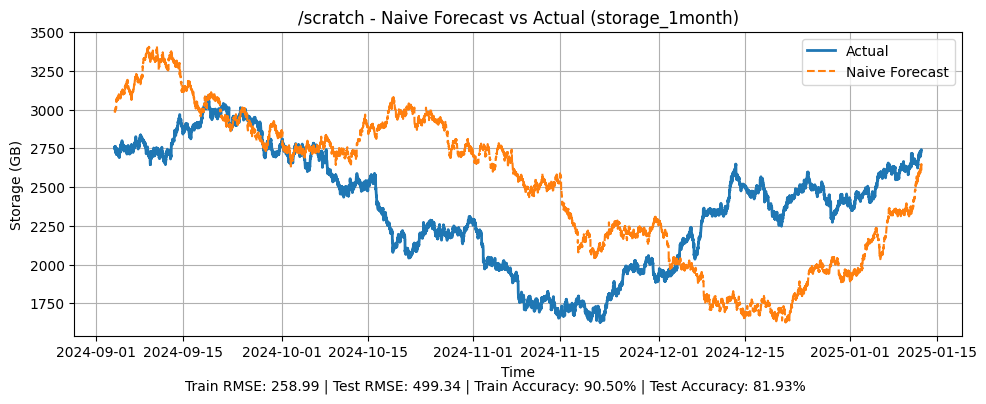

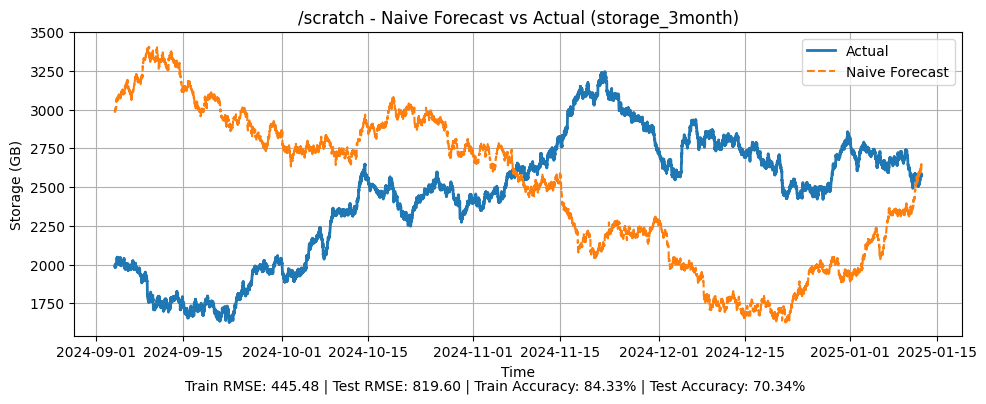


Processing directory: /projects


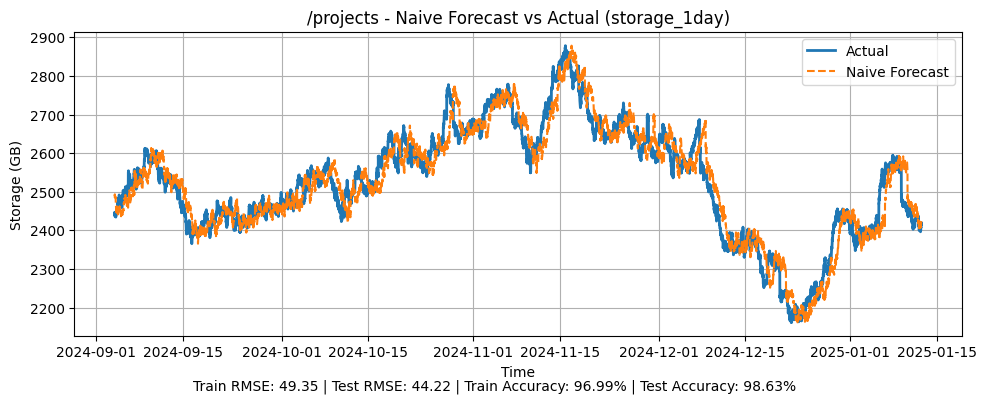

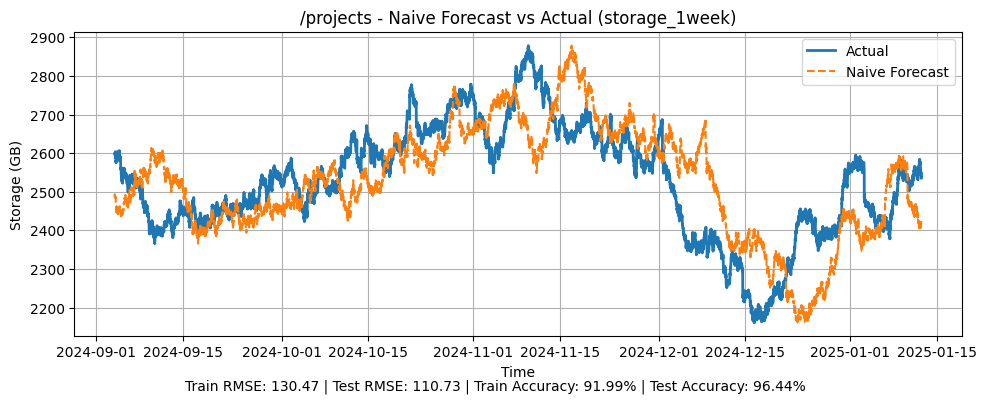

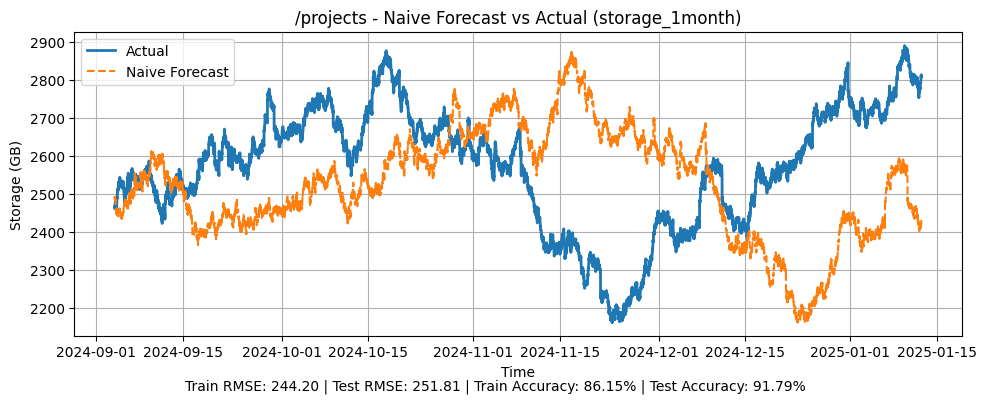

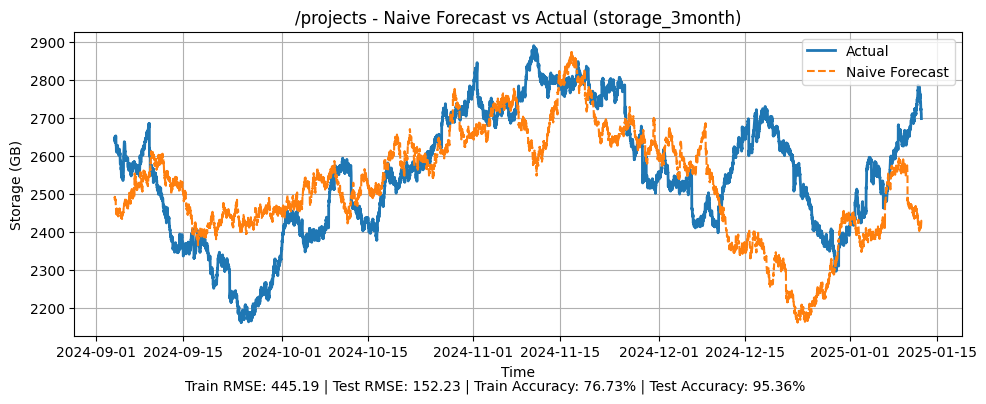


Processing directory: /customer


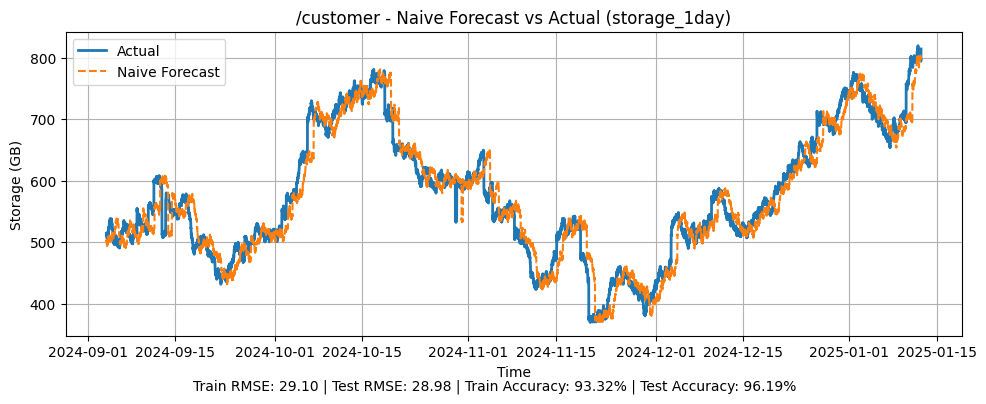

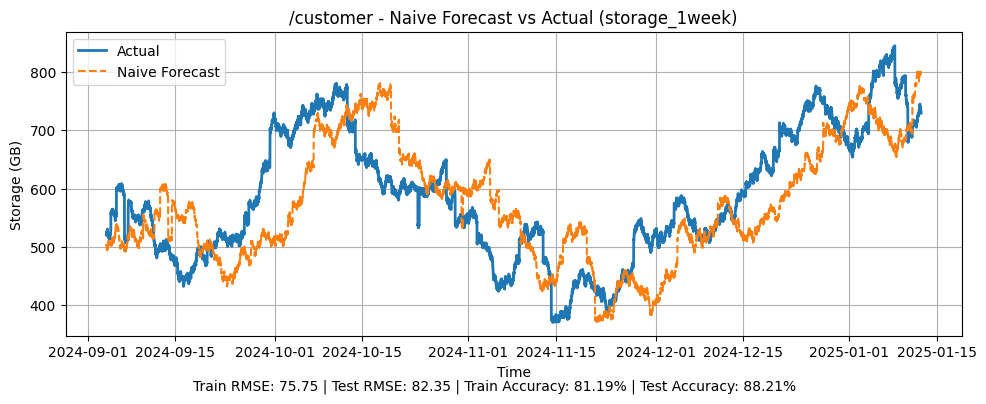

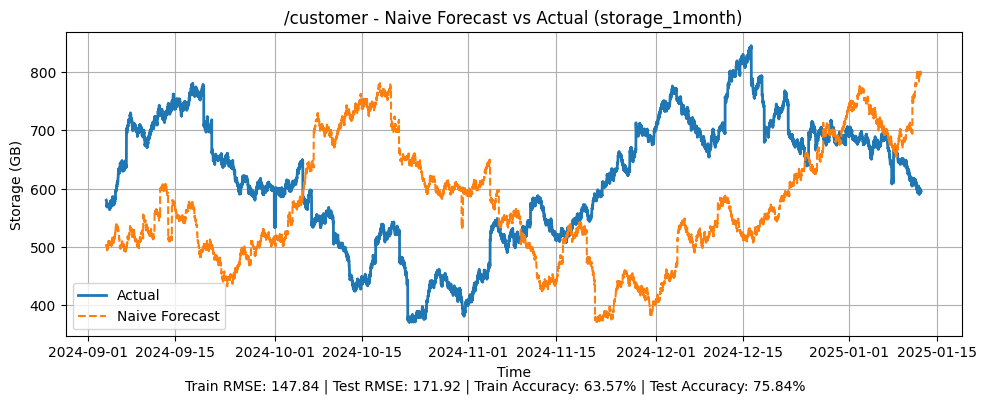

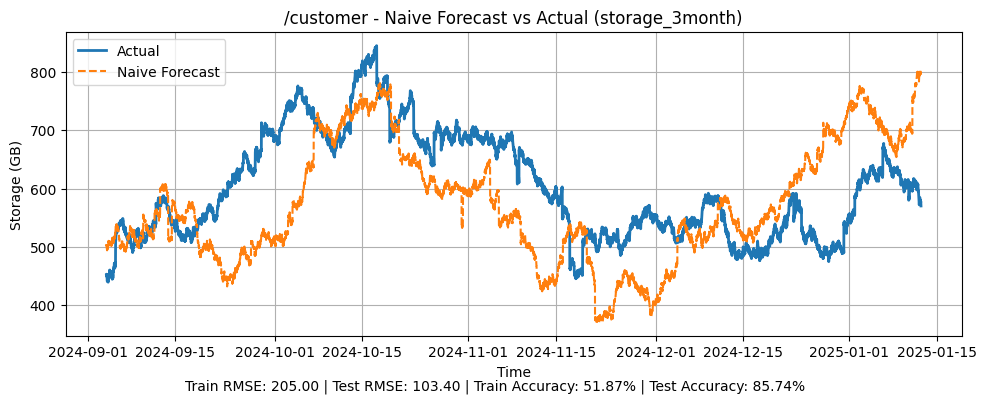


Processing directory: /info


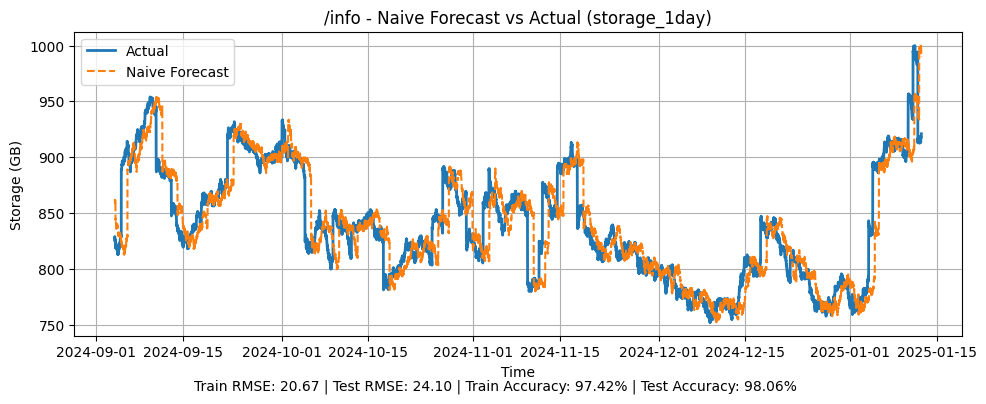

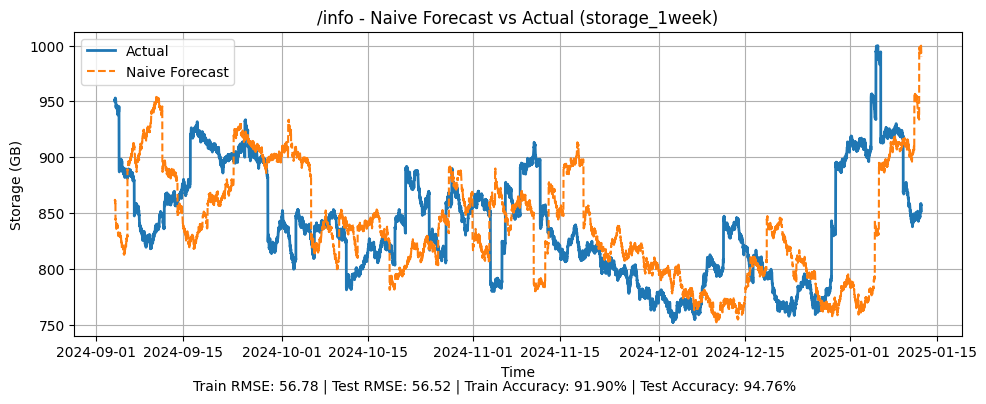

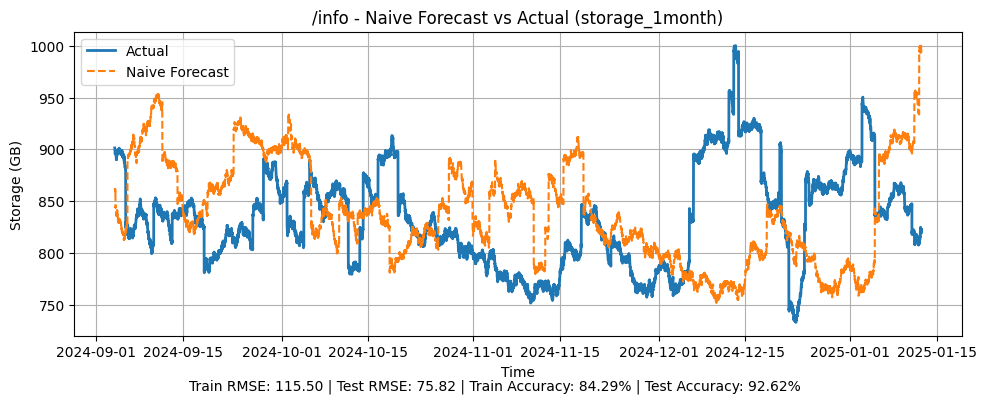

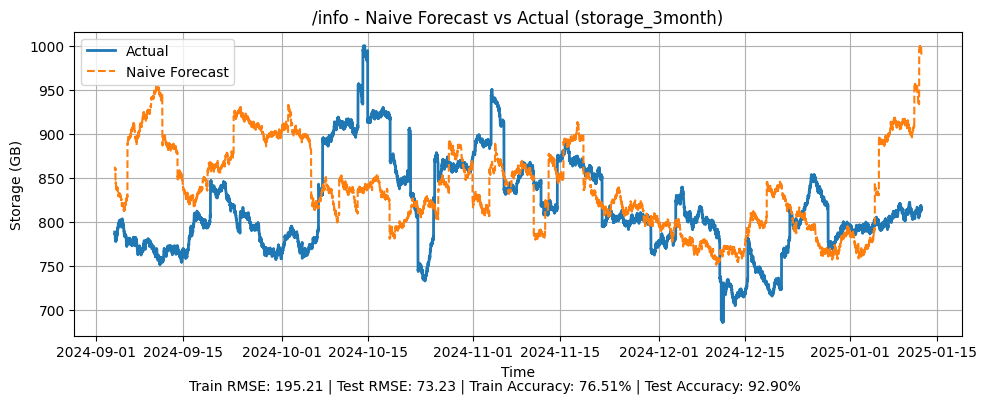

In [15]:
for directory in directories:
    print(f"\nProcessing directory: {directory}")

    # Filter data for current directory
    dir_data = data[data['directory'] == directory].copy()
    dir_data.drop(columns=['directory'], inplace=True)

    # Create forecast target columns
    for name, shift in shifts.items():
        dir_data[name] = dir_data['storage_gb'].shift(-shift)

    dir_data.dropna(inplace=True)

    if len(dir_data) < 200:
        print(f"Skipping {directory} due to insufficient data")
        continue

    # Train-test split
    split_idx = int(len(dir_data) * 0.8)
    train = dir_data.iloc[:split_idx]
    test = dir_data.iloc[split_idx:]

    results = {}

    for target in shifts.keys():
        y_train = train[target]
        y_test = test[target]

        # Naive forecast
        y_train_pred = train['storage_gb']
        y_test_pred = test['storage_gb']

        # Metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        train_mae = mean_absolute_error(y_train, y_train_pred)
        train_acc = 100 - (train_mae / y_train.mean() * 100)

        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_mae = mean_absolute_error(y_test, y_test_pred)
        test_acc = 100 - (test_mae / y_test.mean() * 100)

        results[target] = {
            'Train RMSE': train_rmse,
            'Test RMSE': test_rmse,
            'Train Accuracy (%)': train_acc,
            'Test Accuracy (%)': test_acc
        }

        # Plot
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.plot(y_test.index, y_test, label='Actual', linewidth=2)
        ax.plot(y_test.index, y_test_pred, label='Naive Forecast', linestyle='--')
        ax.set_title(f'{directory} - Naive Forecast vs Actual ({target})')
        ax.set_xlabel('Time')
        ax.set_ylabel('Storage (GB)')
        ax.legend()
        ax.grid(True)

        # Leave space at the bottom for metrics
        plt.subplots_adjust(bottom=0.25)

        # Display metrics below the plot
        metrics_text = (
            f"Train RMSE: {train_rmse:.2f} | "
            f"Test RMSE: {test_rmse:.2f} | "
            f"Train Accuracy: {train_acc:.2f}% | "
            f"Test Accuracy: {test_acc:.2f}%"
        )
        plt.figtext(0.5, 0.01, metrics_text, wrap=True, ha='center', fontsize=10)

        plt.tight_layout()
        plt.show()


# NOTE:
This means your naive model generalizes well for short-term forecasts
naive forecast underperforms over longer horizons. It struggles to capture underlying trends and seasonal effects not necessarily overfitting, but more a limitation of the naive method.

Train RMSE: Measures average prediction error on training data.

Test RMSE: Measures prediction error on unseen (test) data.

Train/Test Accuracy (%): Computed from MAE as a relative measure. Higher = better.

Train RMSE ≈ Test RMSE: Suggests generalization — model is not overfitting.

Test RMSE ≫ Train RMSE: Indicates overfitting — model memorized training but fails on test.

Train RMSE ≫ Test RMSE: Rare, might suggest data leakage or underfitting.